<a href="https://colab.research.google.com/github/fockspaces/ML2021spring/blob/main/HW2%20Phoneme%20Classification/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 2-1 Phoneme Classification**

* Slides: https://speech.ee.ntu.edu.tw/~hylee/ml/ml2021-course-data/hw/HW02/HW02.pdf
* Video (Chinese): https://youtu.be/PdjXnQbu2zo
* Video (English): https://youtu.be/ESRr-VCykBs


## The DARPA TIMIT Acoustic-Phonetic Continuous Speech Corpus (TIMIT)
The TIMIT corpus of reading speech has been designed to provide speech data for the acquisition of acoustic-phonetic knowledge and for the development and evaluation of automatic speech recognition systems.

This homework is a multiclass classification task, 
we are going to train a deep neural network classifier to predict the phonemes for each frame from the speech corpus TIMIT.

link: https://academictorrents.com/details/34e2b78745138186976cbc27939b1b34d18bd5b3

## Download Data
Download data from google drive, then unzip it.

You should have `timit_11/train_11.npy`, `timit_11/train_label_11.npy`, and `timit_11/test_11.npy` after running this block.<br><br>
`timit_11/`
- `train_11.npy`: training data<br>
- `train_label_11.npy`: training label<br>
- `test_11.npy`:  testing data<br><br>

**notes: if the google drive link is dead, you can download the data directly from Kaggle and upload it to the workspace**




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !gdown --id '1HPkcmQmFGu-3OknddKIa5dNDsR05lIQR' --output data.zip
!cp "/content/drive/MyDrive/timit_11_v2.zip 的副本" "data.zip"
!unzip data.zip
!ls 

Archive:  data.zip
   creating: timit_11/
  inflating: timit_11/train_11.npy   
  inflating: timit_11/test_11.npy    
  inflating: timit_11/train_label_11.npy  
data.zip  drive  sample_data  timit_11


## Preparing Data
Load the training and testing data from the `.npy` file (NumPy array).

In [4]:
import numpy as np

print('Loading data ...')

data_root='./timit_11/'
train = np.load(data_root + 'train_11.npy')
train_label = np.load(data_root + 'train_label_11.npy')
test = np.load(data_root + 'test_11.npy')

print('Size of training data: {}'.format(train.shape))
print('Size of testing data: {}'.format(test.shape))

Loading data ...
Size of training data: (1229932, 429)
Size of testing data: (451552, 429)


In [5]:
def sample(data, stride):
  base = data.copy()
  for step in range(1, stride+1, 1):
    Rshift = np.roll(base,step,axis=0)
    data = np.concatenate((Rshift,data), axis=1)
  for step in range(-1, -1-1*stride, -1):
    Lshift = np.roll(base,step,axis=0)
    data = np.concatenate((data,Lshift), axis=1)

  data = np.reshape(data, (-1,2*stride+1,39))
  return data

def normalize(data):
  mean = np.mean(data, axis=0)
  std = np.std(data, axis=0)
  return (data - mean)/std

In [6]:
stride = 25
# (,429)split to(11,39)
train = np.reshape(train, (-1,11,39))
test = np.reshape(test, (-1,11,39))

# pick only the 5th MFCC which is corresponding to the label
train = train[:,5,:]
test = test[:,5,:]

# include nearby MFCC (To extend the frame length)
train = sample(train, stride)
test = sample(test, stride)

# transform to 4d input array (with kernel)
train = np.reshape(train, (-1,1,(2*stride+1),39))
test = np.reshape(test, (-1,1,(2*stride+1),39))

# normalize data
# train = normalize(train)
# test = normalize(test)

In [7]:
train.shape

(1229932, 1, 51, 39)

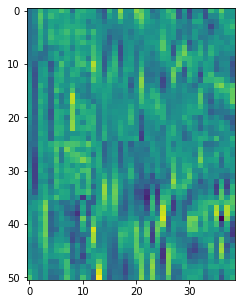

In [8]:
import matplotlib.pyplot as plt
mfcc = np.reshape(train[0], ((2*stride+1),39))
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc);

## Create Dataset

In [9]:
import torch
from torch.utils.data import Dataset

class TIMITDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.from_numpy(X).float()
        if y is not None:
            y = y.astype(np.int)
            self.label = torch.LongTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)


Split the labeled data into a training set and a validation set, you can modify the variable `VAL_RATIO` to change the ratio of validation data.

In [10]:
VAL_RATIO = 0

percent = int(train.shape[0] * (1 - VAL_RATIO))
# train_x, train_y, val_x, val_y = train[:], train_label[:], train[percent:], train_label[percent:]
val_x, val_y = train[percent:], train_label[percent:]
# print('Size of training set: {}'.format(train_x.shape))
# print('Size of validation set: {}'.format(val_x.shape))

In [11]:
# train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], -1)
# test_x = test.reshape(test.shape[0], 1, test.shape[1], -1)
# train_x.shape

Create a data loader from the dataset, feel free to tweak the variable `BATCH_SIZE` here.

In [12]:
BATCH_SIZE = 1024

from torch.utils.data import DataLoader

train_set = TIMITDataset(train, train_label)
val_set = TIMITDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True) #only shuffle the training data
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Cleanup the unneeded variables to save memory.<br>

**notes: if you need to use these variables later, then you may remove this block or clean up unneeded variables later<br>the data size is quite huge, so be aware of memory usage in colab**

In [13]:
import gc

del train, train_label, val_x, val_y
gc.collect()

0

## Create Model

Define model architecture, you are encouraged to change and experiment with the model architecture.

In [14]:
import torch
import torch.nn as nn

class FC(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(429, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, 39) 

        self.act_fn = nn.Sigmoid()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)

        x = self.layer2(x)
        x = self.act_fn(x)

        x = self.layer3(x)
        x = self.act_fn(x)

        x = self.out(x)
        
        return x



In [15]:
import torch.nn.functional as F
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [1, num, 29]
        self.cnn_layers = nn.Sequential(
            #1st
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            #2nd
            nn.Conv2d(32, 32, 5, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            #3rd
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            #4th
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            #5rd
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            #6th
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),
            nn.Dropout(0.5),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(48 * 8*8, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, 39)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)
        return x

## Training

In [16]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

Fix random seeds for reproducibility.

In [17]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

Feel free to change the training parameters here.

In [18]:
# fix random seed for reproducibility
same_seeds(0)

# get device 
device = get_device()
print(f'DEVICE: {device}')

# training parameters
num_epoch = 300               # number of training epoch
learning_rate = 1e-4       # learning rate

# the path where checkpoint saved
model_path = './CNNmodel_25.ckpt'

# create model, define a loss function, and optimizer
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cuda


In [ ]:
# start training

best_acc = 0.0
for epoch in range(num_epoch):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0

    # training
    model.train() # set the model to training mode
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1) # get the index of the class with the highest probability
        batch_loss.backward() 
        optimizer.step() 

        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()

    # validation
    if len(val_set) > 0:
        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item() # get the index of the class with the highest probability
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))

            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, num_epoch, train_acc/len(train_set), train_loss/len(train_loader)
        ))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print('saving model at last epoch')


[001/300] Train Acc: 0.434875 Loss: 2.045172
[002/300] Train Acc: 0.589202 Loss: 1.394590
[003/300] Train Acc: 0.631506 Loss: 1.239109
[004/300] Train Acc: 0.657273 Loss: 1.146511
[005/300] Train Acc: 0.674855 Loss: 1.082932
[006/300] Train Acc: 0.687993 Loss: 1.034096
[007/300] Train Acc: 0.698865 Loss: 0.992555
[008/300] Train Acc: 0.709210 Loss: 0.959811
[009/300] Train Acc: 0.716937 Loss: 0.930360
[010/300] Train Acc: 0.724081 Loss: 0.905309
[011/300] Train Acc: 0.730530 Loss: 0.881355
[012/300] Train Acc: 0.735908 Loss: 0.860807
[013/300] Train Acc: 0.740832 Loss: 0.842603
[014/300] Train Acc: 0.746223 Loss: 0.824322
[015/300] Train Acc: 0.750329 Loss: 0.809233
[016/300] Train Acc: 0.754263 Loss: 0.795010
[017/300] Train Acc: 0.757430 Loss: 0.781823
[018/300] Train Acc: 0.761398 Loss: 0.769405
[019/300] Train Acc: 0.763933 Loss: 0.758426
[020/300] Train Acc: 0.767190 Loss: 0.749261
[021/300] Train Acc: 0.770095 Loss: 0.737424
[022/300] Train Acc: 0.772890 Loss: 0.728403
[023/300] 

## Testing

Create a testing dataset, and load model from the saved checkpoint.

In [ ]:
!cp -r "/content/CNNmodel_25.ckpt" "/content/drive/MyDrive/"

In [ ]:
# create testing dataset
test_set = TIMITDataset(test, None)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# create model and load weights from checkpoint
model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

Make prediction.

In [ ]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [ ]:
count = 0
for i in range(1, len(predict)-1):
    step = 1
    previous_ = predict[i-step]
    next_ = predict[i+step]
    current_ = predict[i]
    if (previous_ != current_) and (next_ != current_) and (previous_ == next_):
        print('idx',i,'correct', current_, 'to', previous_)
        predict[i] = previous_
        count +=1

print('total number of correction %d, correction percent %.2f'% (count, count/len(predict)))

for i in range(1, len(predict)-1):
    step = 2
    if i == 1 or i == len(predict)-2: step = 1
    previous_ = predict[i-step]
    next_ = predict[i+step]
    current_ = predict[i]
    if (previous_ != current_) and (next_ != current_) and (previous_ == next_):
        print('idx',i,'correct', current_, 'to', previous_)
        predict[i] = previous_
        count +=1

print('total number of correction %d, correction percent %.2f'% (count, count/len(predict)))



Write prediction to a CSV file.

After finish running this block, download the file `prediction.csv` from the files section on the left-hand side and submit it to Kaggle.

In [ ]:
with open('predictionCNN_25.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(i, y))

In [ ]:
!cp -r "/content/predictionCNN_25.csv" "/content/drive/MyDrive/"